# Lab 12: Hypothesis Testing

# 0. Intro
Welcome to Lab 12!

Today's lab will review the idea of hypothesis testing using random permutations. This technique is described in the [Permutation chapter of the textbook](http://www.inferentialthinking.com/chapter5/permutation.html) and is used often in practice.

#### Administrative details
Lab submissions are due by **Friday, April 15 at 7:00 PM**.

As usual, if you attend lab section and make a good effort but don't finish during the 2 hours, let your TA know, and you'll get full credit for the lab.  If you do that, please finish the lab on your own time (or in office hours, of course).

In [99]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.assignment import load_assignment 
lab12 = load_assignment('lab12.ok')

Assignment: Lab 12
OK, version v1.5.1



# 1. Comparing Samples

Many studies generate a table that describes multiple attributes for each element in a sample of a population. One important step in studying some aspect of the world via such a sample is to identify associations. An association between a *treatment* attribute and an *outcome* attribute in a population is any relation between them: the outcome varies in some way with the treatment. 

In a random sample, the outcome may appear associated with the treatment because there is in fact an association in the population, or simply because the sample happened to come out that way. The purpose of statistical hypothesis testing is to account quantitatively for the possibility that two attributes may appear related in a sample even though they are not related in the population.

In this lab, we will review the *permutation test* techique from lecture and further investigate the dataset of married couples and unmarried partners to identify associations. The data are based on a study conducted in 2010 under the auspices of the National Center for Family and Marriage Research. 

The rows describe individual people who all participate in a two-person heterosexual relationship. The columns describe:
- **ID**: An identifier for each couple
- **Gender**: The self-reported sex of each individual
- **Marital Status**: Whether the person is married to the individual with the same ID
- **Relationship Rating**: How satisfied is the person with her/his relationship? 1 is most satisfied; 5 is least satisfied
- **Age**: Age in years
- **Education**: Self-reported highest level of education achieved
- **Household Income**: Self-reported household income in a range of dollars
- **Employment Status**: Employment situation at the time the survey was collected

In [100]:
couples = Table.read_table('couples.csv')
couples

ID,Gender,Marital Status,Relationship Rating,Age,Education,Household Income,Employment Status
0,male,married,1,51,Bachelor's degree,"75,000 to 84,999",working as paid employee
0,female,married,1,53,High school graduate - diploma or the equivalent (GED),"75,000 to 84,999",working as paid employee
1,male,married,1,57,Associate degree,"85,000 to 99,999",working as paid employee
1,female,married,1,57,High school graduate - diploma or the equivalent (GED),"85,000 to 99,999",working as paid employee
2,male,married,1,60,Bachelor's degree,"75,000 to 84,999",working as paid employee
2,female,married,1,57,"Some college, no degree","75,000 to 84,999",working as paid employee
3,male,married,1,62,High school graduate - diploma or the equivalent (GED),"35,000 to 39,999","working, self-employed"
3,female,married,1,59,High school graduate - diploma or the equivalent (GED),"35,000 to 39,999",working as paid employee
4,male,married,2,53,"Some college, no degree","125,000 to 149,999",not working - other
4,female,married,2,61,"Some college, no degree","125,000 to 149,999",not working - retired


Here are some statistics about this data set.

In [101]:
print('Number of individuals:', couples.num_rows)
for label in couples.labels:
    print('Number of unique', label, 'values:', couples.group(label).num_rows)

Number of individuals: 2066
Number of unique ID values: 1033
Number of unique Gender values: 2
Number of unique Marital Status values: 2
Number of unique Relationship Rating values: 5
Number of unique Age values: 47
Number of unique Education values: 13
Number of unique Household Income values: 20
Number of unique Employment Status values: 7


## 1.1. Contingency Tables

Before conducting a statistical test for whether a sample association is likely to be due to chance (as opposed to an association in the population), we can use visualization to identify some possible associations.

**Question 1.1.1.** Assign `ratings_by_gender` to a 5-row table that has the following three columns.
- **Relationship Rating**: The rating of an individual
- **female**: The count of all females who gave that rating
- **male**: The count of all males who gave that rating

*Hint:* The final table should look like this:

| Relationship Rating | female | male |
|---------------------|--------|------|
| 1                   |        |      |
| 2                   |        |      |
| 3                   |        |      |
| 4                   |        |      |
| 5                   |        |      ||


*Hint 2:* The Permutation chapter of the textbook describes a method for making contingency tables like this one.

In [102]:
ratings_by_gender = couples.pivot('Gender', 'Relationship Rating') # SOLUTION
ratings_by_gender

Relationship Rating,female,male
1,633,680
2,318,284
3,34,31
4,32,33
5,16,5


In [103]:
_ = lab12.grade("q111")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Now run the next cell to see the two distributions of relationship ratings for females and males.  (Remember that 1 is the best rating and 5 is the worst.)

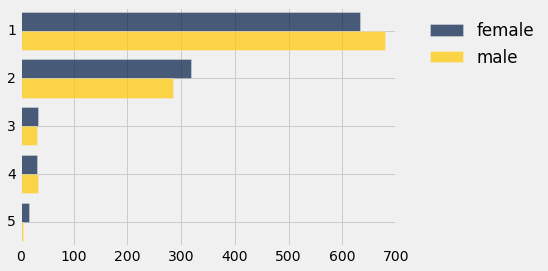

In [104]:
ratings_by_gender.barh(0)

**Question 1.1.2.** Assign `rating_difference` to a 4-row table that has the following three columns.

- **Rating Difference**: The difference between the relationship ratings given by the two members of the same couple
- **married**: The number of *married couples* who reported that rating difference
- **partner**: The number of *unmarried couples* (partners) who reported that rating difference

The `diffs` table defined for you provides part of the solution, but you must figure out how to use it.

*Hint*: The `np.ptp` function takes a list of values and returns the maximum minus the minimum. The acronym "ptp" stands for *peak to peak*. The final table should look like this:

| Rating Difference | married | partner |
|-------------------|---------|---------|
| 0                 |         |         |
| 1                 |         |         |
| 2                 |         |         |
| 3                 |         |         |

In [133]:
# The following table should be helpful.  Either read the code
# or print out part of the table to see what it is.
diffs = couples.select(['ID', 'Marital Status', 'Relationship Rating']).groups(['ID', 'Marital Status'], np.ptp)

# You fill in this part:
rating_difference = diffs.relabeled(2, 'Rating Difference').pivot('Marital Status', 'Rating Difference') # SOLUTION



ID,Marital Status,Relationship Rating ptp
0,married,0
1,married,0
2,married,0
3,married,0
4,married,0
5,married,0
6,married,1
7,married,0
8,married,1
9,married,0


In [106]:
couples

ID,Gender,Marital Status,Relationship Rating,Age,Education,Household Income,Employment Status
0,male,married,1,51,Bachelor's degree,"75,000 to 84,999",working as paid employee
0,female,married,1,53,High school graduate - diploma or the equivalent (GED),"75,000 to 84,999",working as paid employee
1,male,married,1,57,Associate degree,"85,000 to 99,999",working as paid employee
1,female,married,1,57,High school graduate - diploma or the equivalent (GED),"85,000 to 99,999",working as paid employee
2,male,married,1,60,Bachelor's degree,"75,000 to 84,999",working as paid employee
2,female,married,1,57,"Some college, no degree","75,000 to 84,999",working as paid employee
3,male,married,1,62,High school graduate - diploma or the equivalent (GED),"35,000 to 39,999","working, self-employed"
3,female,married,1,59,High school graduate - diploma or the equivalent (GED),"35,000 to 39,999",working as paid employee
4,male,married,2,53,"Some college, no degree","125,000 to 149,999",not working - other
4,female,married,2,61,"Some college, no degree","125,000 to 149,999",not working - retired


In [107]:
_ = lab12.grade("q112")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.1.3.** Complete the function `proportions` that takes a table and a list of labels for columns containing counts. It returns a table with the same number of columns and rows, but with counts replaced by proportions and formatted as percentages for each `count_label`. 

*Hint*: Use `table = table.with_column(label, ...)` with an existing label to create a new table with one of the columns replaced.

*Hint 2*: Recall that `table.set_format(<column name>, PercentFormatter(0))` will set the format of a column to percentages (with 0 decimal places).

In [108]:
def proportions(table, count_labels):
    for label in count_labels:
        column = table.column(label) # SOLUTION
        table = table.with_column(label, column / sum(column)) # SOLUTION
        table.set_format(label, PercentFormatter(0))
    return table

proportions(rating_difference, ['married', 'partner'])

Rating Difference,married,partner
0,70%,64%
1,26%,27%
2,2%,7%
3,2%,2%


In [109]:
_ = lab12.grade("q113")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



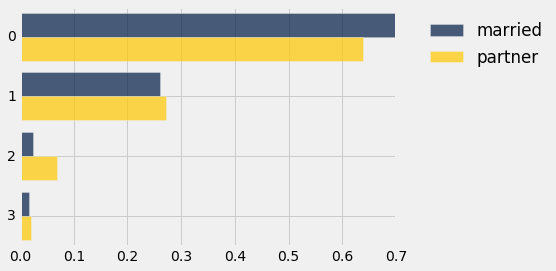

In [110]:
proportions(rating_difference, ['married', 'partner']).barh(0)

**Question 1.1.4.** Do married couples in our sample rate their relationship higher than unmarried partners? Draw a bar chart to compare the **proportion** of different relationship ratings given by people in these two types of relationships.

*Hint*: The proportion in the `partner` column for relationship rating of 2 should be 39%

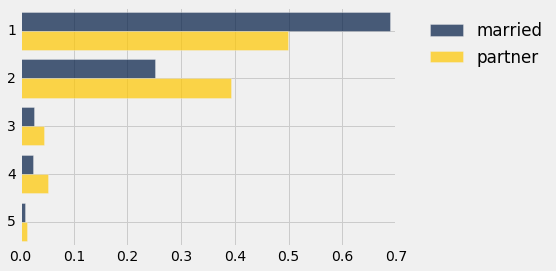

In [111]:
proportions(couples.pivot('Marital Status', 'Relationship Rating'), ['married', 'partner']).barh(0) # SOLUTION

**Question 1.1.5.** Do **females** in the highest income category rate their relationship higher than females in other income categories? Draw a bar chart to compare the **proportion** of different relationship ratings given by females in the highest income category and females in all other brackets.

*Hint*: The proportion in the highest income column for relationship rating 2 should be 29%.

ID,Gender,Marital Status,Relationship Rating,Age,Education,Household Income,Employment Status
0,female,married,1,53,High school graduate - diploma or the equivalent (GED),"75,000 to 84,999",working as paid employee
1,female,married,1,57,High school graduate - diploma or the equivalent (GED),"85,000 to 99,999",working as paid employee
2,female,married,1,57,"Some college, no degree","75,000 to 84,999",working as paid employee
3,female,married,1,59,High school graduate - diploma or the equivalent (GED),"35,000 to 39,999",working as paid employee
4,female,married,2,61,"Some college, no degree","125,000 to 149,999",not working - retired
5,female,married,2,32,Bachelor's degree,"100,000 to 124,999",not working - looking for work
6,female,married,2,47,Master's degree,"75,000 to 84,999","working, self-employed"
7,female,married,2,44,High school graduate - diploma or the equivalent (GED),"60,000 to 74,999",not working - other
8,female,married,2,51,Bachelor's degree,"125,000 to 149,999",working as paid employee
9,female,married,1,59,Master's degree,"150,000 to 174,999",working as paid employee


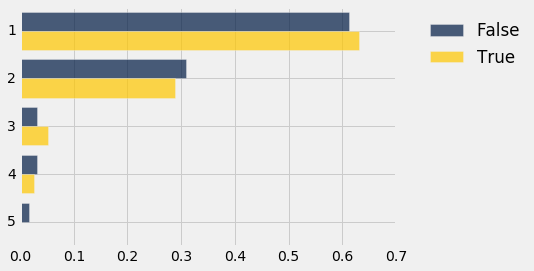

In [130]:
# In our solution, we found it useful to first make a table of the females...
females = couples.where('Gender', 'female') # SOLUTION
# ...then a copy of that table with a column saying whether they were in the
# highest income category.
high_income_females = females.with_column('Rich', females.column('Household Income') == '175,000 or more') # SOLUTION
# Then we made the bar chart here.
proportions(high_income_females.pivot('Rich', 'Relationship Rating'), ['True', 'False']).barh(0) # SOLUTION
females

## 1.2. Comparing distributions

A comparison between two bar charts can be summarized by a single number in various ways. The two we have considered in lecture are the *total variation distance* and the *chi-squared statistic*, both described in [the textbook chapter on Distance Between Distributions](http://www.inferentialthinking.com/chapter5/distance.html).

The `tvd` function (from the textbook) below computes the total variation distance between the distributions of two conditions.

In [132]:
# Just run this cell.

def tvd(t, conditions, values):
    """Compute the total variation distance 
    between proportions of values under two conditions.
    
    t          (Table) -- a table
    conditions (str)   -- a column label in t; should have only two categories
    values     (str)   -- a column label in t
    """
    counts = t.pivot(conditions, values)
    categoryA = np.array(counts.labels).item(1)
    categoryB = np.array(counts.labels).item(2)
    props = proportions(counts, [categoryA, categoryB])
    a = props.column(1)
    b = props.column(2)
    return 0.5*sum(abs(a - b))

tvd(couples, 'Gender', 'Relationship Rating')


0.046466602129719287

**Question 1.2.1.** Assign `diff_tvd` to the total variation distance between the distributions of rating differences for married couples and unmarried partners.

*Hint:* You can use the `diffs` table from question 1.1.2.

In [114]:
diff_tvd = tvd(diffs, 'Marital Status', 'Relationship Rating ptp') #SOLUTION
diff_tvd

0.058937949815211041

In [115]:
_ = lab12.grade("q121")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



For practice, let's consider a third notion of the difference between two distributions: the maximum deviation.  This is just the *biggest* difference (in absolute value) between any two of the bars when we make bar charts of the two distributions.  (Note that we don't divide by 2 like we do when we compute the total variation distance.)

**Question 1.2.2.** Define the `max_deviation` function, which takes the same inputs as `tvd` but computes the maximum deviation between the two distributions, instead of the total variation.

In [116]:
def max_deviation(t, conditions, values):
    """Compute the maximum difference for any value
    between proportions of values under two conditions.
    
    t          (Table) -- a table
    conditions (str)   -- a column label in t; should have only two categories
    values     (str)   -- a column label in t
    """
    counts = t.pivot(conditions, values) #SOLUTION
    categoryA = np.array(counts.labels).item(1) #SOLUTION
    categoryB = np.array(counts.labels).item(2) #SOLUTION
    props = proportions(counts, [categoryA, categoryB]) #SOLUTION
    a = props.column(1) #SOLUTION
    b = props.column(2) #SOLUTION
    return max(abs(a - b)) #SOLUTION

max_deviation(couples, 'Gender', 'Relationship Rating')

0.045498547918683463

In [117]:
_ = lab12.grade("q122")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



# 2. Random Permutations

There is no single threshold for a high (or low) total variation distance. Instead, we compare the observed test statistic to a distribution that is generated empirically by randomly permuting the values in the data. 

The purpose of this comparison is to help us choose between two hypotheses:

*Null hypothesis*: The observed difference between distributions for two conditions is due to chance because we sampled at random to collect the data.

*Alternative hypothesis*: The observed difference is not due to chance, but instead due to an association in the population.

Both hypotheses assume that the data was in fact sampled at random from the population.  A permutation test generates samples that look like the samples we'd see if the null hypothesis were true.

The online textbook provides [an implementation of a permutation test using total variation distance as the test statistic](http://www.inferentialthinking.com/chapter5/permutation.html#Generalizing-Our-Hypothesis-Test). Below, you will extend it to other test statistics.

**Question 2.1.** Complete the implementation of `permutation_test`, which is a generalization of `permutation_tvd` from the textbook, but takes an additional argument `f`, a distance function of three arguments such as `tvd` or `chi2`. Some of the lines left blank below do not need to be changed from the original implementation, but some do.

In [ ]:
def permutation_test(original, conditions, values, f):
    """
    Perform a permutation test of whether 
    the distribution of values for two conditions 
    is the same in the population,
    using the function f to compute the test statistic.
    
    original is a Table with two columns.  The value of the argument
    conditions is the name of one column, and the value of the argument
    values is the name of the other column.  The conditions table should
    have only 2 possible values corresponding to 2 categories in the
    data.
    
    The values column is shuffled many times, and the data are grouped
    according to the conditions column.  The test statistic
    between the proportions values in the 2 categories is computed.  
    
    Then we draw a histogram of all those statistics.  This shows us 
    how the statistic between the two distributions would vary from
    chance, regardless of the conditions.
    """
    # Note: 200 repetitions is a little low.  We've used that number
    # so you don't have to wait too long when you run your code, but
    # if you're concerned about the accuracy of the resulting P-value,
    # feel free to increase it.
    repetitions = 200
    stats = []

    for i in np.arange(repetitions):
        shuffled = original.sample() # SOLUTION
        combined = Table().with_columns([
                conditions, original.column(conditions),
                values,     shuffled.column(values)
            ])
        stats.append(f(combined, conditions, values)) # SOLUTION    

    observation = f(original, conditions, values) # SOLUTION
    p_value = np.count_nonzero(stats >= observation) / repetitions # SOLUTION
    
    print("Observation:", observation)
    print("Empirical P-value:", p_value)
    Table([stats], ['Empirical distribution']).hist()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



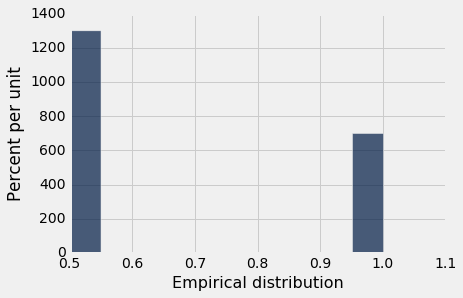

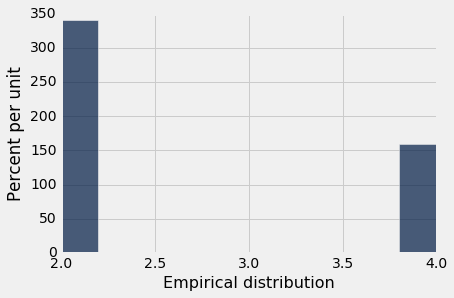

In [119]:
_ = lab12.grade("q21")

## 2.1. Hypothesis Tests

Each hypothesis test has four steps. 

**Step 1** is to state the null and alternative hypotheses. For example, if we are intereted in whether married and unmarried couples rate their relationships differently, we would state the following:

*Null hypothesis:* The difference between how married and unmarried couples rate their relationships is due to the randomness introduced by sampling the data from the population

The alternative is an explanation that is exclusive of the null hypothesis: something is going on more than just random chance from sampling.

*Alternative hypothesis:* The difference between how married and unmarried couples rate their relationships is not due to chance, but instead due to an association in the population.

**Step 2** is to select a test statistic for evaluating the null hypothesis and compute it on our observed data.  The test statistic should be something that generally looks one way if the null hypothesis is true and another way if the alternative hypothesis is true. 

*Test statistic:* The total variation distance between the distributions of relationship ratings for two conditions: married and unmarried couples.

In [120]:
tvd(couples, 'Marital Status', 'Relationship Rating')

0.19107131278887746

**Step 3** is to estimate the probability distribution of this statistic under the null hypothesis. Given only a sample, we can't draw new samples directly from the population. Instead, we randomly permute the pairings of conditions and values to see how the test statistic would vary for a sample of the given size, the split between conditions, and the observed proportions of values.

Observation: 0.191071312789
Empirical P-value: 0.0


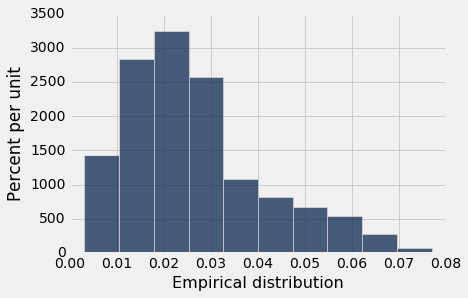

In [121]:
permutation_test(couples, 'Marital Status', 'Relationship Rating', tvd)

**Step 4** is to interpret the result and draw a conclusion. A P-value of 0.05 or below is conventionally called "statistically significant" and a P-value of 0.01 or below is conventionally called "highly statistically significant", although these thresholds are arbitrary.

**Question 2.1.1.** Assign `married_couples_reject_null` to either `True` or `False` to express whether we should reject the null hypothesis that the difference between how married and unmarried couples rate their relationships is due to the randomness introduced by sampling the data from the population, using a maximum p-value of 0.01.

In [122]:
# Fill this in manually, using the result of the permutation test
# in the previous cell.
married_couples_reject_null = True # SOLUTION

In [123]:
_ = lab12.grade("q211")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2.1.2.** Assign `high_income_females_reject_null` to the result of an expression that determines whether we should reject the null hypothesis that the difference between how females in the highest income category and females in all other categories rate their relationship is due to the randomness introduced by sampling the data from the population. Use a maximum p-value of 0.01. Does it matter whether you use `tvd` or `max_deviation` as your test statistic?

Observation: 0.0204707749273
Empirical P-value: 0.99
Observation: 0.0399894207882
Empirical P-value: 0.945


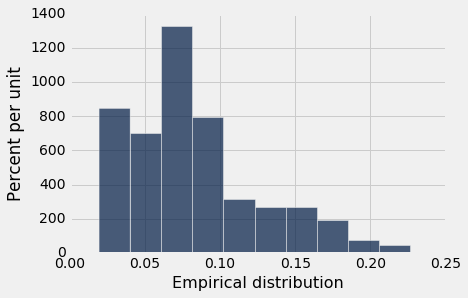

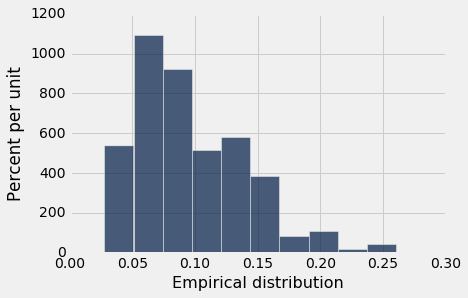

In [124]:
permutation_test(high_income_females, 'Rich', 'Relationship Rating', max_deviation) # SOLUTION
permutation_test(high_income_females, 'Rich', 'Relationship Rating', tvd) # SOLUTION
high_income_females_reject_null = False # SOLUTION

In [125]:
_ = lab12.grade("q212")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



You're done!

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

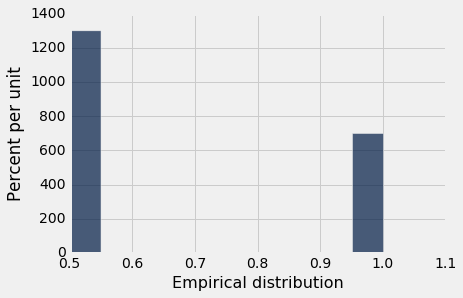

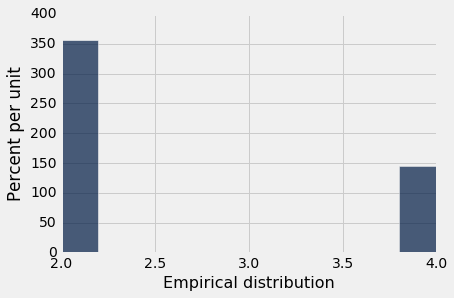

In [126]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [lab12.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

In [127]:
# Run this cell to submit your work *after* you have passed all of the test cells.
# It's ok to run this cell multiple times. Only your final submission will be scored.

!TZ=America/Los_Angeles ipython nbconvert --output=".lab12_$(date +%m%d_%H%M)_submission.html" lab12.ipynb && echo "Submitted successfully."

[NbConvertApp] Converting notebook lab12.ipynb to html
[NbConvertApp] Writing 336907 bytes to .lab12_0430_2054_submission.html
Submitted successfully.
